In [1]:
# Sample connection
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Cleaning connection")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

22/08/23 15:02:33 WARN Utils: Your hostname, DESKTOP-L9KIK4G resolves to a loopback address: 127.0.1.1; using 172.30.17.251 instead (on interface eth0)
22/08/23 15:02:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/23 15:02:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [115]:
from statsmodels.formula.api import ols, glm
# VectorAssembler creates new vectors from existing columns
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, MinMaxScaler, StandardScaler
from pyspark.ml.linalg import Vectors

from pyspark.ml.regression import LinearRegression

import pandas as pd
import numpy as np
import os

In [3]:
sdf = spark.read.parquet('../data/curated/final3/clean_dataset.parquet/')

# Setting apart test set

In [4]:
# set aside 15 days from 2019 to do our testing
# code: https://stackoverflow.com/questions/553303/generate-a-random-date-between-two-other-dates
import random
import time


def str_time_prop(start, end, time_format, prop):
    stime = time.mktime(time.strptime(start, time_format))
    etime = time.mktime(time.strptime(end, time_format))

    ptime = stime + prop * (etime - stime)

    return time.strftime(time_format, time.localtime(ptime))


def random_date(start, end, prop):
    return str_time_prop(start, end, '%Y-%m-%d %H', prop) + ':00:00'


random.seed(42)
test_dates = [[random_date(
    "2019-06-01 00", "2019-08-31 23", random.random())] for x in range(15)]

test_dates_df = spark.createDataFrame(test_dates, ["temp_date"]).select(F.col("temp_date"), F.to_timestamp(
    F.col("temp_date"), 'yyyy-MM-dd HH:mm:ss').alias("dt_truncated")).select(F.col('dt_truncated'))

test_dates_df.join(sdf, on=['dt_truncated'], how='left') \
    .dropDuplicates()\
    .write.mode('overwrite').parquet('../data/temp/test_set/test_data.parquet')

testing_sdf = spark.read.parquet('../data/temp/test_set/test_data.parquet')

# remove those lines from the fitting dataset
sdf.subtract(testing_sdf.select('pickup_datetime', 'PULocationID', 'PUWeekday', 'PUHour', 'PUMonth', 'PUDay', 'dt_truncated',
             'count', 'wnd', 'vis', 'tmp', 'dew', 'atm', 'cc')).write.mode('overwrite').parquet('../data/temp/train_set/train.parquet')


22/08/23 15:05:31 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


# Normalising and one-hot-encoding the data

In [ ]:
testing_sdf = spark.read.parquet('../data/temp/test_set/test_data.parquet')
train_sdf = spark.read.parquet('../data/temp/train_set/train.parquet')


In [8]:

# # onehotencoder = OneHotEncoder(
# #     inputCol='PULocationID',
# #     outputCol='location_vec',
# #     dropLast=False
# # ).fit(sdf)

# # model_sdf = onehotencoder.transform(sdf)

# assembler = VectorAssembler(
#     inputCols=['wnd', 'vis', 'tmp', 'dew', 'atm', 'cc', 'PULocationID'],
#     outputCol='features'
# )

# assembled = assembler.transform(sdf)

# scaler = StandardScaler(inputCol='features',
#                       outputCol='scaledFeatures'
#                       )

# scalerModel = scaler.fit(assembled.select("features"))        # TODO important variable

# # assembler2 = VectorAssembler(
# #     inputCols=['scaledFeatures', 'location_vec'],
# #     outputCol='finalfeature'
# # )

# scaledData = scalerModel.transform(assembled)

# #from pyspark.ml.linalg import Vectors, VectorUDT
# #concat = F.udf(lambda v, e: Vectors.dense(list(v) + list(e.toArray())), VectorUDT())
# #dummy_df = scaledData.withColumn('mergedFeatures', concat(scaledData.scaledFeatures, scaledData.location_vec))
# #dummy_df.show(5, truncate=False)

onehotencoder = OneHotEncoder(
    inputCol='PULocationID',
    outputCol='location_vec'
    ).fit(train_sdf)

ohedata = onehotencoder.transform(train_sdf)

assembler = VectorAssembler(
    inputCols=['wnd', 'vis', 'tmp', 'dew', 'atm', 'cc', 'PUMonth', 'PUWeekday', 'PUDay', 'PUHour', 'location_vec'],
    outputCol='features')
model_sdf = assembler.transform(ohedata)

# Linear regression model

In [9]:
lm = LinearRegression(
    featuresCol='features', 
    labelCol='count'
).fit(model_sdf)

22/08/23 15:22:11 WARN Instrumentation: [1221f262] regParam is zero, which might cause numerical instability and overfitting.


22/08/23 15:23:12 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/08/23 15:23:12 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


22/08/23 15:26:52 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
22/08/23 15:26:52 WARN Instrumentation: [1221f262] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


# Evaluating model

In [11]:
print("Coefficients: " + str(lm.coefficients))
print("Intercept: " + str(lm.intercept))
trainingSummary = lm.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
# print(trainingSummary.residuals.count())
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print(trainingSummary.meanAbsoluteError)
print("r2: %f" % trainingSummary.r2) 

Coefficients: [0.7713354966603598,0.000822832748470652,0.24462086561798435,0.22231060776413364,0.12321608654691817,-3.73287390724969e-06,-19.758227992471557,5.660308764054373,-0.10046171951641789,7.779693129878702,-366.874040271735,-373.3265026920326,-374.26430200930275,-330.4746720849185,-216.51635380107214,-361.3046861693345,-362.6356882351203,-65.64239185800335,-377.057549417982,-352.8084016048737,-305.0815210090018,-347.0523018368584,-360.9572314318466,-83.6014974238533,-250.9608505265881,-357.28575937820244,-324.4247781467671,-133.16494446848213,-275.9110526762259,-351.19570662420944,-314.4830191077919,-311.1942063057035,-299.36513246303497,-349.14512234050983,-292.4321829850697,-189.12779534681488,-245.94762925277766,-384.9027253365899,-325.21444894315954,-329.7866463196723,-370.37814168768824,-356.02284286535473,-321.5997126587646,-192.81603165324006,-356.42396279998525,-237.5751403022863,-119.30843494331242,-79.66070879049292,-346.60554024475715,-183.61059783953706,-285.8818357

In [24]:
residuals = trainingSummary.residuals.sample(0.05, 42).toPandas()

22/08/23 15:55:30 ERROR TaskSetManager: Total size of serialized results of 16 tasks (1083.3 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/08/23 15:55:30 WARN TaskSetManager: Lost task 15.0 in stage 47.0 (TID 418) (172.30.17.251 executor driver): TaskKilled (Tasks result size has exceeded maxResultSize)
22/08/23 15:55:30 WARN TaskSetManager: Lost task 19.0 in stage 47.0 (TID 422) (172.30.17.251 executor driver): TaskKilled (Stage cancelled)
22/08/23 15:55:30 WARN TaskSetManager: Lost task 18.0 in stage 47.0 (TID 421) (172.30.17.251 executor driver): TaskKilled (Stage cancelled)
22/08/23 15:55:30 WARN TaskSetManager: Lost task 16.0 in stage 47.0 (TID 419) (172.30.17.251 executor driver): TaskKilled (Stage cancelled)
22/08/23 15:55:30 WARN TaskSetManager: Lost task 17.0 in stage 47.0 (TID 420) (172.30.17.251 executor driver): TaskKilled (Stage cancelled)


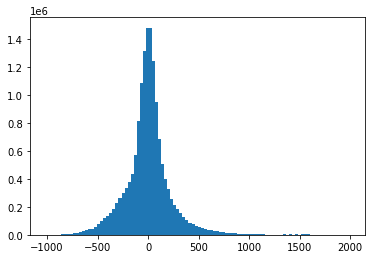

In [29]:
import matplotlib.pyplot as plt

plt.hist(residuals, bins=100)
plt.show()


# Linear reg v2

In [31]:
# print('fitting OHE')
onehotencoder = OneHotEncoder(
    inputCol='PULocationID',
    outputCol='location_vec'
).fit(train_sdf)

# print('one hot encoding')
onehotdata = onehotencoder.transform(train_sdf)

assembler = VectorAssembler(
    inputCols=['wnd', 'vis', 'tmp', 'dew', 'atm', 'cc', 'PUMonth',
               'PUWeekday', 'PUDay', 'PUHour', 'location_vec'],
    outputCol='features'
    )

# print('assembling')
assembled_sdf = assembler.transform(onehotdata)

scaler = StandardScaler(
    inputCol='features',
    outputCol='scaledFeatures'
)
# print('fitting scaler')
scalerModel = scaler.fit(
    assembled_sdf.select("features")
)        # TODO important variable

# print('scaling')
model_sdf = scalerModel.transform(assembled_sdf)

one hot encoding
assembling
fitting scaler


scaling


In [32]:
lm = LinearRegression(
    featuresCol='features', 
    labelCol='count'
).fit(model_sdf)

22/08/23 16:22:30 WARN Instrumentation: [c9fdb863] regParam is zero, which might cause numerical instability and overfitting.


22/08/23 16:26:59 WARN Instrumentation: [c9fdb863] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [40]:
print("Coefficients: " + str(lm.coefficients))
print("Intercept: " + str(lm.intercept))
trainingSummary = lm.summary
print("numIterations: ", trainingSummary.totalIterations)
print("objectiveHistory: ", str(trainingSummary.objectiveHistory))
# print(trainingSummary.residuals.count())
print("RMSE: ", trainingSummary.rootMeanSquaredError)
print("MAE", trainingSummary.meanAbsoluteError)
print("R2:", trainingSummary.r2)


Coefficients: [0.771335496661224,0.0008228327484720362,0.24462086561885799,0.2223106077633378,0.12321608654929757,-3.7328739072288994e-06,-19.758227992418327,5.660308764055657,-0.10046171951684743,7.779693129871784,-366.8740402721216,-373.32650269241816,-374.26430200971265,-330.4746720853066,-216.516353801472,-361.3046861697357,-362.63568823550986,-65.64239185839517,-377.0575494183613,-352.8084016052628,-305.0815210093993,-347.0523018372417,-360.9572314322081,-83.60149742422027,-250.9608505269722,-357.2857593785886,-324.4247781471665,-133.16494446886458,-275.91105267660964,-351.19570662460524,-314.4830191081712,-311.1942063060873,-299.3651324634128,-349.14512234089744,-292.43218298546066,-189.12779534719044,-245.94762925315098,-384.90272533696213,-325.2144489435508,-329.7866463200505,-370.3781416881016,-356.0228428657244,-321.5997126591553,-192.81603165361074,-356.42396280034006,-237.57514030267404,-119.30843494372,-79.66070879088996,-346.6055402451575,-183.6105978399265,-285.881835796

## Predicting
the pickup numbers per zone for those 15 hours we picked out earlier

In [41]:
testing_sdf = spark.read.parquet('../data/temp/test_set/test_data.parquet')

In [44]:
testing_sdf = onehotencoder.transform(testing_sdf)
testing_sdf = assembler.transform(testing_sdf)
testing_sdf = scalerModel.transform(testing_sdf)
testing_sdf.show(5)


+-------------------+-------------------+------------+---------+------+-------+-----+-----+----+-------+-----+----+-------+---+-----------------+--------------------+--------------------+
|       dt_truncated|    pickup_datetime|PULocationID|PUWeekday|PUHour|PUMonth|PUDay|count| wnd|    vis|  tmp| dew|    atm| cc|     location_vec|            features|      scaledFeatures|
+-------------------+-------------------+------------+---------+------+-------+-----+-----+----+-------+-----+----+-------+---+-----------------+--------------------+--------------------+
|2019-06-03 10:00:00|2019-06-03 10:33:30|       198.0|        2|    10|      6|    3|   16|46.0|16093.0|161.0|78.0|10110.0|2.0|(263,[198],[1.0])|(273,[0,1,2,3,4,5...|(273,[0,1,2,3,4,5...|
|2019-06-03 10:00:00|2019-06-03 10:21:30|       196.0|        2|    10|      6|    3|   14|46.0|16093.0|161.0|78.0|10110.0|2.0|(263,[196],[1.0])|(273,[0,1,2,3,4,5...|(273,[0,1,2,3,4,5...|
|2019-06-03 10:00:00|2019-06-03 10:10:51|       238.0|      

In [52]:
lm_predictions = lm.transform(testing_sdf)
lm_predictions.filter(F.col('dt_truncated') =='2019-08-07 17:00:00').drop('pickup_datetime').dropDuplicates().show(2700)#show(5)

+-------------------+------------+---------+------+-------+-----+-----+----+-------+-----+-----+-------+---+-----------------+--------------------+--------------------+------------------+
|       dt_truncated|PULocationID|PUWeekday|PUHour|PUMonth|PUDay|count| wnd|    vis|  tmp|  dew|    atm| cc|     location_vec|            features|      scaledFeatures|        prediction|
+-------------------+------------+---------+------+-------+-----+-----+----+-------+-----+-----+-------+---+-----------------+--------------------+--------------------+------------------+
|2019-08-07 17:00:00|        73.0|        4|    17|      8|    7|    6|77.0|16093.0|289.0|217.0|10082.0|4.0| (263,[73],[1.0])|(273,[0,1,2,3,4,5...|(273,[0,1,2,3,4,5...| 77.33449161115789|
|2019-08-07 17:00:00|       143.0|        4|    17|      8|    7|  160|77.0|16093.0|289.0|217.0|10082.0|4.0|(263,[143],[1.0])|(273,[0,1,2,3,4,5...|(273,[0,1,2,3,4,5...| 345.6894872699837|
|2019-08-07 17:00:00|       174.0|        4|    17|      8| 

In [68]:
# create a dataframe where dt_truncated = '2019-08-07 17:00:00', weather data is from the actual frame and contains every zone from 1 to 263
columns = ['dt_truncated', 'PULocationID', 'wnd', 'vis', 'tmp',
           'dew', 'atm', 'cc', 'PUMonth', 'PUWeekday', 'PUDay', 'PUHour']
data = [('2019-08-07 17:00:00', x, 46.0, 16093.0, 161.0,
         78.0, 10110.0, 2.0,  8, 4, 7, 17) for x in range(1, 264)]

rdd = spark.sparkContext.parallelize(data)
visualisation_sdf = rdd.toDF(columns)

visualisation_sdf = onehotencoder.transform(visualisation_sdf)
visualisation_sdf = assembler.transform(visualisation_sdf)
visualisation_sdf = scalerModel.transform(visualisation_sdf)
visualisation_sdf.show(5)

+-------------------+------------+----+-------+-----+----+-------+---+-------+---------+-----+------+---------------+--------------------+--------------------+
|       dt_truncated|PULocationID| wnd|    vis|  tmp| dew|    atm| cc|PUMonth|PUWeekday|PUDay|PUHour|   location_vec|            features|      scaledFeatures|
+-------------------+------------+----+-------+-----+----+-------+---+-------+---------+-----+------+---------------+--------------------+--------------------+
|2019-08-07 17:00:00|           1|46.0|16093.0|161.0|78.0|10110.0|2.0|      8|        4|    7|    17|(263,[1],[1.0])|(273,[0,1,2,3,4,5...|(273,[0,1,2,3,4,5...|
|2019-08-07 17:00:00|           2|46.0|16093.0|161.0|78.0|10110.0|2.0|      8|        4|    7|    17|(263,[2],[1.0])|(273,[0,1,2,3,4,5...|(273,[0,1,2,3,4,5...|
|2019-08-07 17:00:00|           3|46.0|16093.0|161.0|78.0|10110.0|2.0|      8|        4|    7|    17|(263,[3],[1.0])|(273,[0,1,2,3,4,5...|(273,[0,1,2,3,4,5...|
|2019-08-07 17:00:00|           4|46.0|1

In [102]:
predicted = lm.transform(visualisation_sdf).select(
    'PULocationID', 'prediction')
# predicted.sort('PULocationID')
# predicted.join(testing_sdf.drop('pickup_datetime').dropDuplicates(), on='PULocationID', how='fullouter')\
#     .filter(F.col('dt_truncated') == '2019-08-07 17:00:00').sort('PULocationID')
t_df = testing_sdf.filter(F.col('dt_truncated') == '2019-08-07 17:00:00').select('PULocationID', 'count').dropDuplicates().sort('PULocationID').toPandas()
pred_df = predicted.toPandas()

In [109]:
pred_df.values.tolist()

[[1.0, -32.98321727305108],
 [2.0, -33.921016590345516],
 [3.0, 9.86861333406057],
 [4.0, 123.82693161789518],
 [5.0, -20.961400750368625],
 [6.0, -22.292402816142726],
 [7.0, 274.7008935609721],
 [8.0, -36.71426399899417],
 [9.0, -12.465116185895681],
 [10.0, 35.261764409967896],
 [11.0, -6.709016417874523],
 [12.0, -20.613946012840984],
 [13.0, 256.74178799514686],
 [14.0, 89.38243489239505],
 [15.0, -16.942473959221502],
 [16.0, 15.9185072722006],
 [17.0, 207.1783409505025],
 [18.0, 64.43223274275749],
 [19.0, -10.852421205238102],
 [20.0, 25.860266311195915],
 [21.0, 29.149079113279754],
 [22.0, 40.978152955954215],
 [23.0, -8.801836921530253],
 [24.0, 47.91110243390642],
 [25.0, 151.21549007217675],
 [26.0, 94.3956561662161],
 [27.0, -44.559439917595],
 [28.0, 15.128836475816342],
 [29.0, 10.556639099316612],
 [30.0, -30.034856268734416],
 [31.0, -15.679557446357308],
 [32.0, 18.743572760211805],
 [33.0, 147.52725376575643],
 [34.0, -16.08067738097293],
 [35.0, 102.76814511669306]

In [119]:
result = []
for prediction in pred_df.values.tolist():
    for actual in t_df.values.tolist():
        if prediction[0] == actual[0]:
            result.append([int(prediction[0]), int(actual[1]), prediction[1],  prediction[1] - int(actual[1])])
            break
    else:
        result.append([int(prediction[0]), 0, prediction[1], prediction[1]])

if not os.path.exists('../data/curated/visualisation/'):
    os.makedirs('../data/curated/visualisation/')
pd.DataFrame(result, columns=['PULocationID', 'actual', 'predicted', 'diff'])\
    .to_csv('../data/curated/visualisation/2019august.csv', index=False)
